In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import yaml
import warnings
warnings.filterwarnings("ignore")

In [2]:
# データ準備
X_train = pd.read_csv('../data/processed/train_x_add_features.csv')
test_df = pd.read_csv('../data/processed/test_x_add_features.csv')

y_train = X_train['win']
X_train.drop(['win'], axis=1, inplace=True)
X_test = test_df.drop(['id', 'win'], axis=1)

print(X_train.shape, X_test.shape, y_train.shape, test_df.shape)

(144000, 42) (36000, 42) (144000,) (36000, 44)


In [3]:
config_path = '../configs/config_lgbm_cvmean.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)


# 交差検証の設定
n_splits = 5
optimal_threshold = config['threshold']['optimal']
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=71)

len(X_train) // n_splits

28800

# クロスバリデーション

In [4]:
# LightGBMのパラメータ設定
params = config['model']['lgbm']

cv_train_scores = []
cv_valid_scores = []
cv_train_auc = []
cv_valid_auc = []
oof_predictions = np.zeros(X_train.shape[0]) # Out-of-Fold predictions
test_predictions = np.zeros(X_test.shape[0])
feature_importance_list = []
best_iterations = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f'Fold {fold} / {n_splits}')
    
    # データ分割
    X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    # LightGBMデータセット作成
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    valid_data = lgb.Dataset(X_valid_fold, label=y_valid_fold, reference=train_data)


    # モデル訓練
    model = lgb.train(
        params,
        train_data,
        num_boost_round=config['model']['learning_control']['num_boost_round'],
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=config['model']['learning_control']['early_stopping_rounds'], verbose=False),
            lgb.log_evaluation(period=0) # ログ出力を無効化
        ]
    )

    # 予測
    y_train_pred = model.predict(X_train_fold, num_iteration=model.best_iteration)
    y_valid_pred = model.predict(X_valid_fold, num_iteration=model.best_iteration)

    # Out-of-Fold予測更新
    oof_predictions[valid_idx] = y_valid_pred # type: ignore

    # テストデータの予測を累積
    test_predictions += model.predict(X_test, num_iteration=model.best_iteration) / n_splits # type: ignore

    # 評価
    train_acc = accuracy_score(y_train_fold, (y_train_pred > optimal_threshold).astype(int)) # type: ignore
    valid_acc = accuracy_score(y_valid_fold, (y_valid_pred > optimal_threshold).astype(int)) # type: ignore
    train_auc = roc_auc_score(y_train_fold, y_train_pred) # type: ignore
    valid_auc = roc_auc_score(y_valid_fold, y_valid_pred) # type: ignore

    cv_train_scores.append(train_acc)
    cv_valid_scores.append(valid_acc)
    cv_train_auc.append(train_auc)
    cv_valid_auc.append(valid_auc)

    best_iterations.append(model.best_iteration)

    print(f"Train Accuracy: {train_acc:.4f} | AUC: {train_auc:.4f}")
    print(f"Valid Accuracy: {valid_acc:.4f} | AUC: {valid_auc:.4f}")
    print(f"Best iteration: {model.best_iteration}\n")

    

    # 特徴量重要度の保存
    feature_importance_list.append(model.feature_importance(importance_type='gain'))

# oof全体の評価
oof_acc = accuracy_score(y_train, (oof_predictions > optimal_threshold).astype(int)) # type: ignore
oof_auc = roc_auc_score(y_train, oof_predictions) # type: ignore
print(f"OOF Accuracy: {oof_acc:.4f} | AUC: {oof_auc:.4f}")

Fold 1 / 5
Train Accuracy: 0.8814 | AUC: 0.9578
Valid Accuracy: 0.8553 | AUC: 0.9378
Best iteration: 532

Fold 2 / 5
Train Accuracy: 0.8846 | AUC: 0.9595
Valid Accuracy: 0.8534 | AUC: 0.9367
Best iteration: 575

Fold 3 / 5
Train Accuracy: 0.8870 | AUC: 0.9610
Valid Accuracy: 0.8534 | AUC: 0.9366
Best iteration: 620

Fold 4 / 5
Train Accuracy: 0.8945 | AUC: 0.9655
Valid Accuracy: 0.8572 | AUC: 0.9385
Best iteration: 781

Fold 5 / 5
Train Accuracy: 0.9029 | AUC: 0.9703
Valid Accuracy: 0.8588 | AUC: 0.9399
Best iteration: 990

OOF Accuracy: 0.8556 | AUC: 0.9379


In [5]:
import sys
sys.path.append('../src')
from ExperimentLogger import ExperimentLogger
exp_logger = ExperimentLogger(config_path=config_path)
exp_logger.log_experiment(
    cv_valid_auc=cv_valid_auc,
    cv_valid_acc=cv_valid_scores,
    oof_auc=oof_auc,
    oof_acc=oof_acc,
    best_iterations=best_iterations  # オプション
)


Experiment: lgbm_cvmean_v1
OOF AUC: 0.9379 | Accuracy: 0.8556
CV AUC:  0.9379 ± 0.0012
CV ACC:  0.8556 ± 0.0021
Saved to: ../outputs/experiments/lgbm_cvmean_v1.json



In [6]:
# 各Foldの結果
results_df = pd.DataFrame({
    'Fold': range(1, n_splits + 1),
    'Train Acc': cv_train_scores,
    'Valid Acc': cv_valid_scores,
    'Train AUC': cv_train_auc,
    'Valid AUC': cv_valid_auc
})

print(results_df.to_string(index=False))

# 平均と標準偏差
print(f"\n{'='*50}")
print(f"平均と標準偏差:")
print(f"{'='*50}")
print(f"Valid Accuracy: {np.mean(cv_valid_scores):.4f} ± {np.std(cv_valid_scores):.4f}")
print(f"Valid AUC:      {np.mean(cv_valid_auc):.4f} ± {np.std(cv_valid_auc):.4f}")

print(f"\n{'='*50}")
print(f"Out-of-Fold 全体評価:")
print(f"{'='*50}")
print(f"OOF Accuracy: {oof_acc:.4f}")
print(f"OOF AUC:      {oof_auc:.4f}")

 Fold  Train Acc  Valid Acc  Train AUC  Valid AUC
    1   0.881380   0.855313   0.957782   0.937777
    2   0.884583   0.853437   0.959461   0.936701
    3   0.887040   0.853403   0.961021   0.936590
    4   0.894505   0.857153   0.965485   0.938520
    5   0.902899   0.858750   0.970341   0.939945

平均と標準偏差:
Valid Accuracy: 0.8556 ± 0.0021
Valid AUC:      0.9379 ± 0.0012

Out-of-Fold 全体評価:
OOF Accuracy: 0.8556
OOF AUC:      0.9379


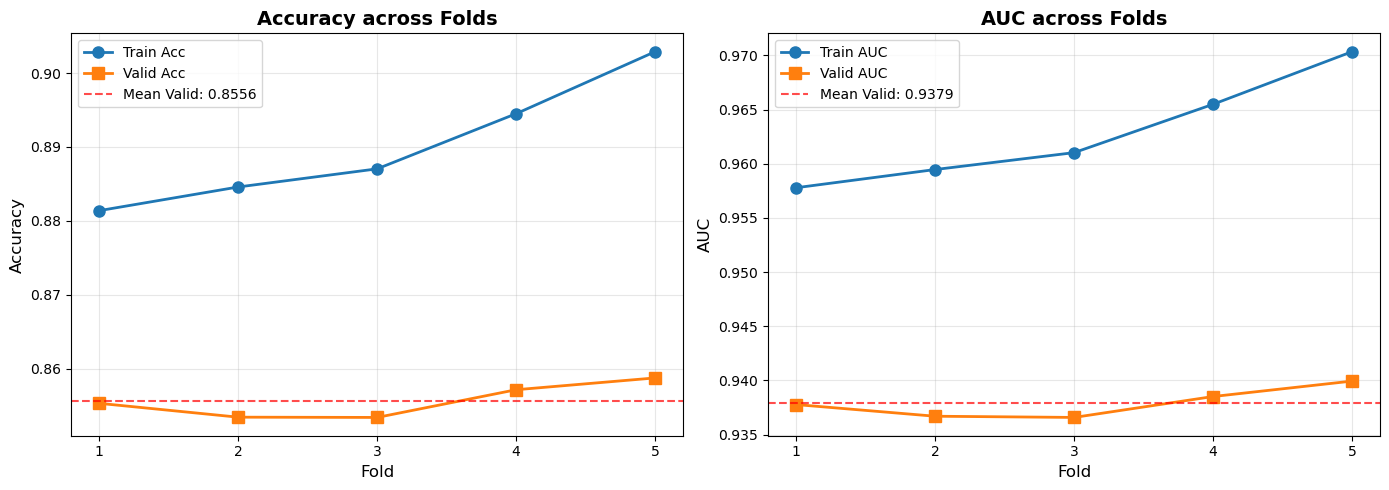

In [7]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 各Foldのスコア
folds = range(1, n_splits + 1)
axes[0].plot(folds, cv_train_scores, 'o-', label='Train Acc', linewidth=2, markersize=8)
axes[0].plot(folds, cv_valid_scores, 's-', label='Valid Acc', linewidth=2, markersize=8)
axes[0].axhline(np.mean(cv_valid_scores), color='red', linestyle='--', 
                label=f'Mean Valid: {np.mean(cv_valid_scores):.4f}', alpha=0.7)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy across Folds', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(folds)

# AUC
axes[1].plot(folds, cv_train_auc, 'o-', label='Train AUC', linewidth=2, markersize=8)
axes[1].plot(folds, cv_valid_auc, 's-', label='Valid AUC', linewidth=2, markersize=8)
axes[1].axhline(np.mean(cv_valid_auc), color='red', linestyle='--', 
                label=f'Mean Valid: {np.mean(cv_valid_auc):.4f}', alpha=0.7)
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('AUC across Folds', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(folds)

plt.tight_layout()
plt.show()

In [8]:
# テストデータの最終予測(全Fold平均)
y_test_pred_binary = (test_predictions > optimal_threshold).astype(int)

save_path = '../outputs/submissions/submission_lgbm_cvmean_v2.csv'
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'win': y_test_pred_binary
})
submission_df.to_csv(save_path, index=False)


In [9]:
# 過学習の度合いをチェック
train_valid_gap = np.mean(cv_train_scores) - np.mean(cv_valid_scores)
train_valid_gap_auc = np.mean(cv_train_auc) - np.mean(cv_valid_auc)

In [10]:
print(train_valid_gap, train_valid_gap_auc)

0.03447048611111114 0.02491150270854736
